# Synthetic data, Hawkes processes

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pointprocesses as ppr
import itertools

In [3]:
import os
import sys
import tqdm

In [4]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Notebook dir /home/manifold/Documents/etudes/map511-p3a


In [5]:
for path in sys.path:
    print(path)

/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload

/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


The standard Hawkes model has an underlying intensity given by
$$
    \lambda_t = \lambda^0_t + \int_0^t g(t-s)\,dN_s
$$
where the function $g \geq 0$ is called the _kernel_.

Here we simulate Hawkes processes with kernel $g(t) = \alpha\exp(-\delta t)$.

# Tick

In [6]:
import tick
import tick.hawkes
from tick.plot import plot_point_process

In [7]:
def fuse_node_times(e):
    """
    Given timestamps from a simulated process, fuse timestamps
    from both nodes, with the tagged event types.
    """
    n_nodes = len(e)
    type_list = [
        i*np.ones_like(e[i], dtype=int) for i in range(n_nodes)
    ]
    concat_times = np.concatenate(e)
    sorting_indices = concat_times.argsort()
    type_arr = np.concatenate(type_list)[sorting_indices]
    return concat_times[sorting_indices], type_arr

## 1D

$$
    g(t) = \alpha\beta\exp(-\beta t)
$$

In [37]:
mu = 0.2
tmax = 3600.
alpha = 0.1
beta  = 2.

hawkes = tick.hawkes.SimuHawkesExpKernels(
    [[alpha]],
    [[beta]],
    baseline=[mu],
    end_time=tmax,
    verbose=False
)

mu*tmax/(1-hawkes.spectral_radius())

800.0

In [38]:
hawkes.reset()
hawkes.track_intensity(0.01)
hawkes.simulate()

In [39]:
hawkes.n_total_jumps

765

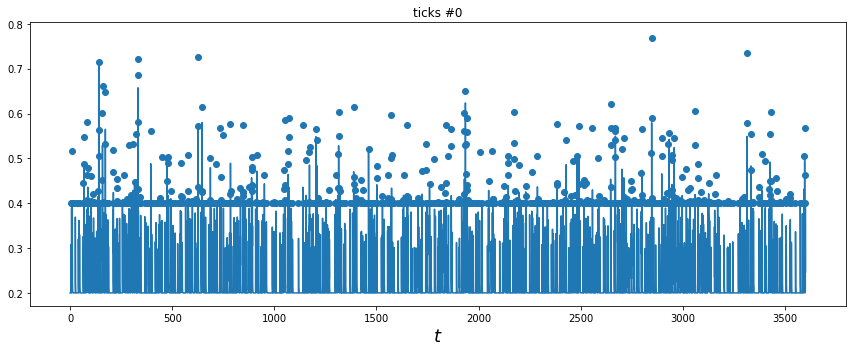

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
_ = plot_point_process(hawkes, ax=ax)
fig.tight_layout()

In [65]:
hawkes_mass = tick.hawkes.SimuHawkesExpKernels(
    [[alpha]],
    [[beta]],
    baseline=[mu],
    end_time=tmax,
    verbose=False,
)
n_simulations = 6000
print("est. no. of events:", mu*tmax/(1-hawkes_mass.spectral_radius()))

est. no. of events: 800.0


In [66]:
hawkes_mass.reset()
multi = tick.hawkes.SimuHawkesMulti(hawkes_mass, n_simulations=n_simulations,
                                    n_threads=3)

In [67]:
multi.simulate()

In [68]:
import datetime
now = datetime.datetime.now()

date_format = "%Y%m%d-%H%M%S"
file_timestamp = now.strftime(date_format)
file_timestamp

filepath = os.path.join('..', 'data', 'simulated', 'hawkes_synthetic_exp_1d_{}.pkl'
                        .format(file_timestamp))
print(filepath)

../data/simulated/hawkes_synthetic_exp_1d_20181205-142133.pkl


In [69]:
tagged_timestamps = [
    fuse_node_times(e) for e in multi.timestamps
]

event_timestamps, event_types = list(zip(*tagged_timestamps))

import pickle
if os.path.exists(filepath):
    print("Warning! File already exists")
    confirm = input("Confirm ? [y/N]")
    if confirm in ["y", "Y", "yes"]:
        save_ = True
        print("Overwritten.")
    else:
        save_ = False
        print("Operation canceled.")
else:
    save_ = True
if save_:
    with open(filepath, "wb") as f:
        save_data_ = {
            "mu": mu,
            "alpha": alpha,
            "decay": beta,
            "tmax": tmax,
            "timestamps": event_timestamps,
            "types": event_types,
            "lengths": multi.n_total_jumps
        }

        pickle.dump(save_data_, f)

## 2D Hawkes process

In [8]:
seed = 653

In [72]:
mu = 0.1
adjacency_2d = np.array([
    [0.1, 0.01],
    [0.01, 0.1]
])
decay_2d = 1
baseline_2d = np.array([mu, mu])

In [77]:
tmax = 3600

In [78]:
hawkes_2d = tick.hawkes.SimuHawkesExpKernels(
    adjacency_2d,
    decay_2d,
    baseline=baseline_2d,
    end_time=tmax,
    verbose=False
)

In [79]:
tmax*np.linalg.norm(baseline_2d, ord=1)/(1-hawkes_2d.spectral_radius())

808.9887640449438

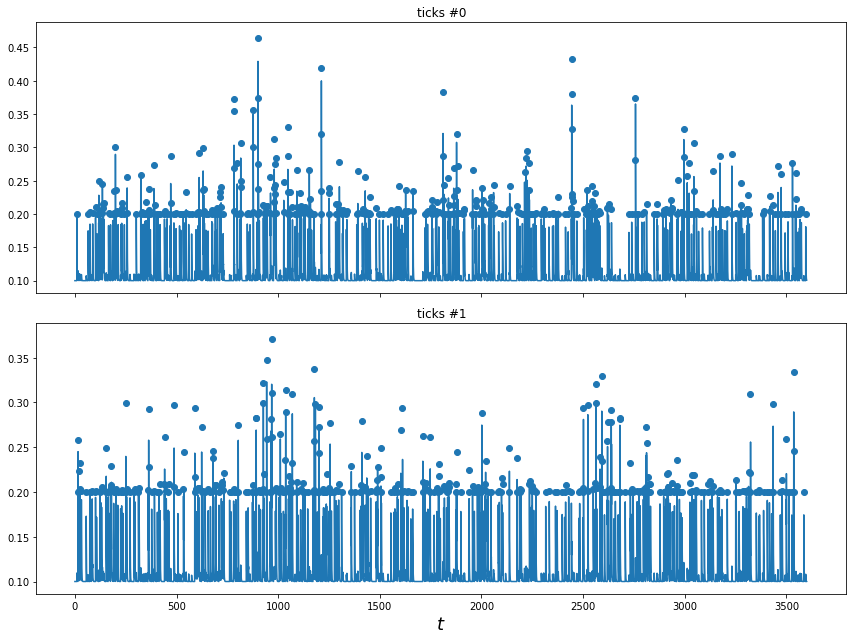

In [80]:
hawkes_2d.reset()
hawkes_2d.track_intensity(0.01)
hawkes_2d.simulate()

fig, ax = plt.subplots(2, 1, figsize=(12, 9), sharex=True)
_ = plot_point_process(hawkes_2d, ax=ax)
fig.tight_layout()

In [81]:
sum(len(e) for e in hawkes_2d.timestamps)

803

In [82]:
hawkes_2d.reset()
hawkes_2d.track_intensity(-1)
multi_2d = tick.hawkes.SimuHawkesMulti(hawkes_2d, n_simulations=4000,
                                       n_threads=4)

In [83]:
multi_2d.simulate()

In [84]:
tagged_timestamps = [
    fuse_node_times(e) for e in multi_2d.timestamps
]

event_timestamps, event_types = list(zip(*tagged_timestamps))

In [85]:
import datetime

In [86]:
now = datetime.datetime.now()

date_format = "%Y%m%d-%H%M%S"
file_timestamp = now.strftime(date_format)
file_timestamp

filepath = os.path.join('..', 'data', 'simulated', 'hawkes_synthetic_exp_2d_{}.pkl'.format(file_timestamp))
print(filepath)

../data/simulated/hawkes_synthetic_exp_2d_20181207-194103.pkl


In [87]:
import pickle
if os.path.exists(filepath):
    print("Warning! File already exists")
    confirm = input("Confirm ? [y/N]")
    if confirm in ["y", "Y", "yes"]:
        save_ = True
        print("Overwritten.")
    else:
        save_ = False
        print("Operation canceled.")
else:
    save_ = True
if save_:
    with open(filepath, "wb") as f:
        save_data_ = {
            "mu": baseline_2d,
            "alpha": adjacency_2d,
            "decay": decay_2d,
            "tmax": tmax,
            "timestamps": event_timestamps,
            "types": event_types,
            "lengths": multi_2d.n_total_jumps
        }
        pickle.dump(save_data_, f)